In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [3]:
import sys
sys.path.append(r'C:\Users\HP\week 11 final\time_series_modeling\scripts')  

import data_loading

[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                          TSLA       TSLA       TSLA       TSLA   
Date                                                                    
2015-01-02 00:00:00+00:00  14.620667  14.620667  14.883333  14.217333   
2015-01-05 00:00:00+00:00  14.006000  14.006000  14.433333  13.810667   
2015-01-06 00:00:00+00:00  14.085333  14.085333  14.280000  13.614000   
2015-01-07 00:00:00+00:00  14.063333  14.063333  14.318667  13.985333   
2015-01-08 00:00:00+00:00  14.041333  14.041333  14.253333  14.000667   

Price                           Open    Volume  
Ticker                          TSLA      TSLA  
Date                                            
2015-01-02 00:00:00+00:00  14.858000  71466000  
2015-01-05 00:00:00+00:00  14.303333  80527500  
2015-01-06 00:00:00+00:00  14.004000  93928500  
2015-01-07 00:00:00+00:00  14.223333  44526000  
2015-01-08 00:00:00+00:00  14.187333  51637500  



C:\Users\HP\week 11 final\time_series_modeling\scripts\data_loading.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [4]:
# Assuming you have the preprocessed data from data_loading.py
data = data_loading.load_stock_data("TSLA", "2015-01-01", "2024-10-31")
preprocessed_data = data_loading.preprocess_data(data)

# Extract closing prices for TSLA
tsla_close = preprocessed_data['Close']

[*********************100%***********************]  1 of 1 completed
C:\Users\HP\week 11 final\time_series_modeling\scripts\data_loading.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [5]:
# Train-test split 
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [6]:
preprocessed_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2015-01-02 00:00:00+00:00,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05 00:00:00+00:00,14.006000,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06 00:00:00+00:00,14.085333,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07 00:00:00+00:00,14.063333,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08 00:00:00+00:00,14.041333,14.041333,14.253333,14.000667,14.187333,51637500


In [7]:
# Load data (assuming you have a CSV file with 'Date' and 'Adj Close' columns)
data = preprocessed_data

In [8]:
# Prepare data for LSTM
def create_dataset(dataset, look_back=60):
  X, y = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    X.append(a)
    y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(y)


In [9]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1, 1))

In [10]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [11]:
# Reshape input to be [samples, time steps, features]
look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [12]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\HP\11 final\time_series_modeling\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # Monitor validation loss


In [15]:
# Train the model with Early Stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0229 - val_loss: 0.0020
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.7282e-04 - val_loss: 0.0020
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.2289e-04 - val_loss: 0.0022


In [16]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [17]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('LSTM Model:')
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)

LSTM Model:
Mean Squared Error: 51926.24425475754
Root Mean Squared Error: 227.87330746438369
Mean Absolute Error: 225.52010551065217
Mean Absolute Percentage Error: 442.67591809730305


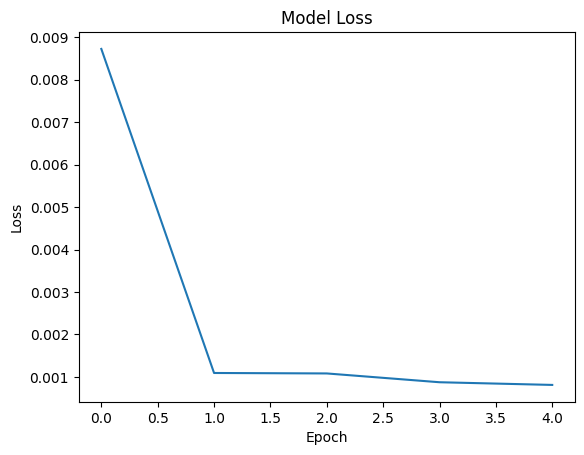

In [18]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

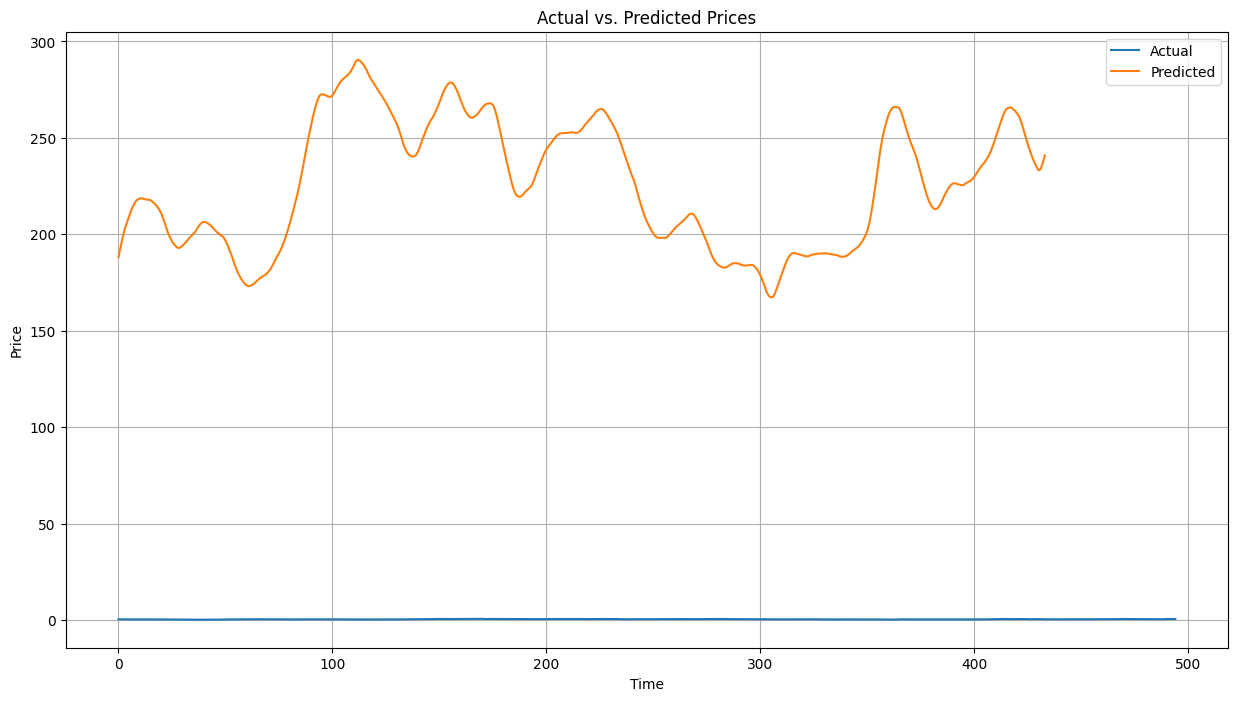

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prepare future data for forecasting
future_data = test[-look_back:]  # Use the last 'look_back' values from the test set
future_data = future_data.reshape((1, look_back, 1))

In [ ]:
# Make predictions for the future
future_predictions = model.predict(future_data)
future_predictions = scaler.inverse_transform(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [ ]:
# Assuming 'data' has a Datetime index
last_train_date = data.index[train_size - 1]
forecast_dates = [last_train_date + pd.DateOffset(days=i) for i in range(len(future_predictions))]

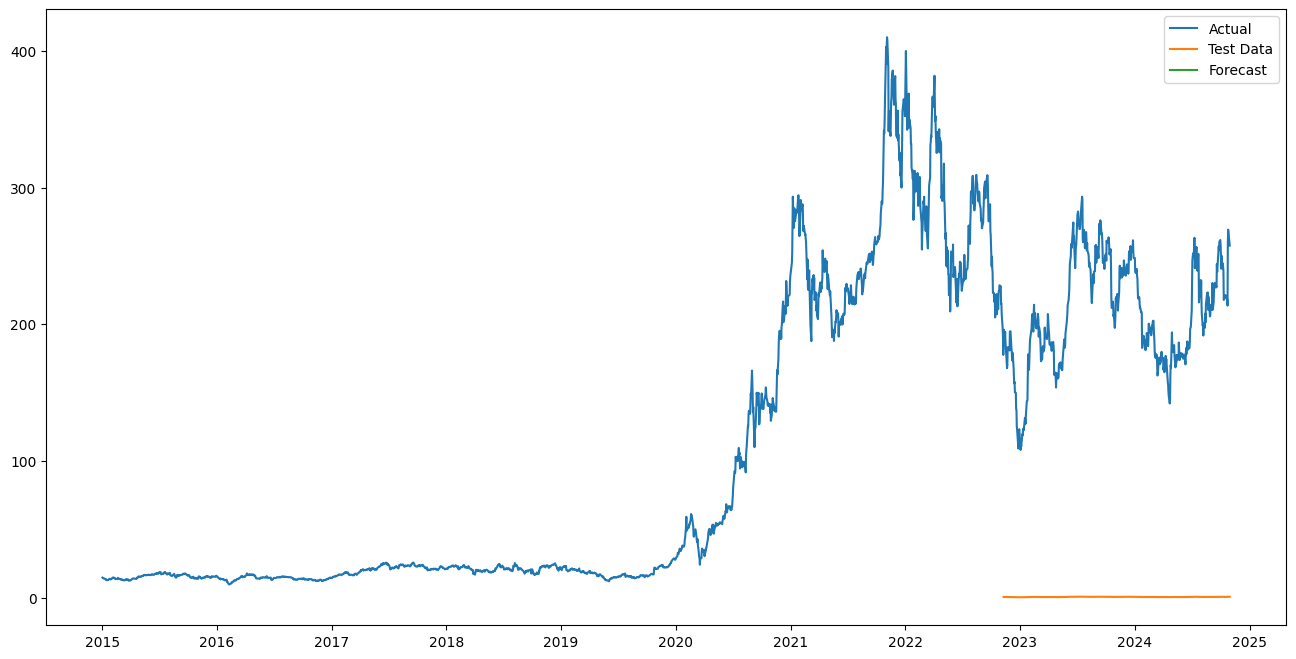

In [ ]:
# Visualize the results
plt.figure(figsize=(16, 8))
plt.plot(data['Adj Close'], label='Actual')
plt.plot(data[train_size:].index, test, label='Test Data')
plt.plot(forecast_dates, future_predictions, label='Forecast')
plt.legend()
plt.show()